# OLS and polynomial regression

## 1. Ordinary Least Squares

In [1]:
import pylab as pl
import scipy as sp
from numpy.linalg import inv
from scipy.io import loadmat
%matplotlib inline

We implement ordinary least squares regression (OLS) with an optional ridge parameter. In ```ols_train```, we estimate a linear mapping $W$,    
$$W = (X_{\text{train}}X_{\text{train}}^{\top} + \lambda I)^{-1}X_{\text{train}}Y_{\text{train}}^{\top}$$       
that optimally predicts the training labels from the training data, $X_{\text{train}} \in \mathbb{R}^{D_X \times N_{tr}}$,  $Y_{\text{train}} \in\mathbb{R}^{D_Y \times N_{tr}}$. Here, $\lambda \in \mathbb R$ is the (optional) Ridge regularization parameter.  
The function ```ols_apply``` than uses the weight vector to predict the (unknown) hand positions of new test data $X_{\text{test}} \in\mathbb{R}^{D_X \times N_{te}}$     
$$Y_{\text{test}} = W^{\top}X_{\text{test}}$$         

The data set ```myo_data.mat``` consists of preprocessed EMG data $X$ and 2-dimensional stimulus labels $Y$. Labels are x/y positions of the hand during different hand movements. The function  ```load_myo_data```  loads the data and splits it into train and test data.

In [ ]:
def load_myo_data(fname):
    ''' Loads EMG data from <fname>                      
    '''
    # load the data
    data = loadmat(fname)
    # extract data and hand positions
    X = data['training_data']
    X = sp.log(X)
    Y = data['training_labels']
    #Split data into training and test data
    X_train = X[:, :5000]
    X_test = X[:, 5000:]
    Y_train = Y[:, :5000]
    Y_test = Y[:, 5000:]
    return X_train,Y_train,X_test, Y_test

def train_ols(X_train, Y_train, llambda = 0):
    ''' Trains ordinary least squares (ols) regression 
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
                 llabmda  -  Regularization parameter
    Output:      W        -  DxD2 array, linear mapping used to estimate labels 
                             with sp.dot(W.T, X)                      
    '''
    
    X = X_train
    Y = Y_train
    
    W = sp.dot(inv(sp.dot(X,X.T) + llambda * sp.identity(X.shape[0])),sp.dot(X,Y.T))
    
    return W
    
def apply_ols(W, X_test):
    ''' Applys ordinary least squares (ols) regression 
    Input:       X_test    -  DxN array of N data points with D features
                 W        -  DxD2 array, linear mapping used to estimate labels 
                             trained with train_ols                   
    Output:     Y_test    -  D2xN array
    '''
    
    Y_test = sp.dot(W.T,X_test)
    
    return Y_test
    
def predict_handposition():
    X_train,Y_train,X_test, Y_test = load_myo_data('myo_data.mat')
    # compute weight vector with linear regression
    W = train_ols(X_train, Y_train)
    # predict hand positions
    Y_hat_train = apply_ols(W, X_train)
    Y_hat_test = apply_ols(W, X_test) 
        
    pl.figure(figsize=(8,6))
    pl.subplot(2,2,1)
    pl.plot(Y_train[0,:1000],Y_train[1,:1000],'.k',label = 'true')
    pl.plot(Y_hat_train[0,:1000],Y_hat_train[1,:1000],'.r', label = 'predicted')
    pl.title('Training Data')
    pl.xlabel('x position')
    pl.ylabel('y position')
    pl.legend(loc = 0)
    
    pl.subplot(2,2,2)
    pl.plot(Y_test[0,:1000],Y_test[1,:1000],'.k')
    pl.plot(Y_hat_test[0,:1000],Y_hat_test[1,:1000],'.r')
    pl.title('Test Data')
    pl.xlabel('x position')
    pl.ylabel('y position')
    
    pl.subplot(2,2,3)
    pl.plot(Y_train[1,:600], 'k', label = 'true')
    pl.plot(Y_hat_train[1,:600], 'r--', label = 'predicted')
    pl.xlabel('Time')
    pl.ylabel('y position')
    pl.legend(loc = 0)
    
    pl.subplot(2,2,4)
    pl.plot(Y_test[1,:600],'k')
    pl.plot(Y_hat_test[1,:600], 'r--')
    pl.xlabel('Time')
    pl.ylabel('y position')
    
def test_OLS():
    ##Example without noise
    x_train = sp.array([[ 0,  0,  1 , 1],[ 0,  1,  0, 1]])
    y_train = sp.array([[0, 1, 1, 2]])
    w_est = train_ols(x_train, y_train) 
    w_est_ridge = train_ols(x_train, y_train, llambda = 1)
    assert(sp.all(w_est.T == [[1, 1]])) 
    assert(sp.all(w_est_ridge.T == [[.75, .75]]))
    y_est = apply_ols(w_est,x_train)
    assert(sp.all(y_train == y_est)) 
    print ('No-noise-case tests passed')
    
    ##Example with noise
    #Data generation
    w_true = 4
    X_train = sp.arange(10)
    X_train = X_train[None,:]
    Y_train = w_true * X_train + sp.random.normal(0,2,X_train.shape)
    #Regression 
    w_est = train_ols(X_train, Y_train) 
    Y_est = apply_ols(w_est,X_train)
    #Plot result
    pl.figure()
    pl.plot(X_train.T, Y_train.T, '+', label = 'Train Data')
    pl.plot(X_train.T, Y_est.T, label = 'Estimated regression')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 'lower right')

No-noise-case tests passed


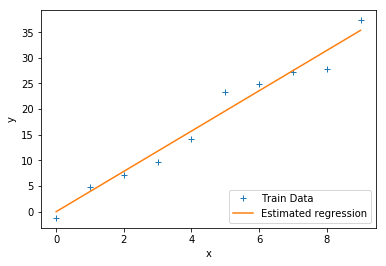

In [3]:
test_OLS()

There seems to be a slight performance difference train and test dataset. Especially
when you look at xy positions in the test data set that weren't really existant in the train
data set. Those xy positions (in the test set) don't seem to get predicted as well as other
positions that were included in the train set. This is not surprising as the plots show what
is called 'training accuracy' (how well can my model fit to a given data set) and 'test
accuracy' (how well can my trained model predict unseen data). Training accuracy is naturally
higher (also given the almost equal sizes of test and train set).

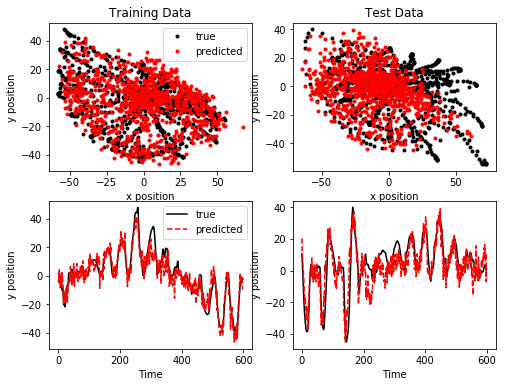

In [4]:
predict_handposition()

Note: As expected,if you comment the line where we logarithmize the data-points the performance (both train- and test-accurrcy) is worse. This is because we use linear classification which only works well for a model that behaves more or less linearly. This is the case when you look a the log-datapoints of the data, less so when you look at the actual datapoints (data-set specific!).

Note 2: If we cannot predict the labels $Y$ perfectly by a linear regression on $X$, does this imply that the relationship between $X$ and $Y$ is non-linear?
This is one possible interpretation. The other one is that there is noise in the data. Even if the noise has gaussian shape (here, ols is ideal in terms of zero bias and minimal variance) there is still an error between my regression estimator and the actual ('real world') phenomenon.

## 2: Polynomial Regression

We first create toy data from a sine function as follows:           
$$x_i \in \{0, 1, 2, \ldots, 10\}, y_i = \sin(x_i) + \epsilon_i, \; \; \epsilon_i \sim \mathcal{N}(0, 0.5)$$        
where $\mathcal{N}$(mean, standard deviation) denotes the Gaussian distribution and $i \in \{1, 2, \ldots, 11\}$ is an index. Then, we implement polynomial regression, which models the relationship between $y$ and $x$ as an $m$th order polynomial, i.e. 
$\hat{y} = w_0 + w_1 x + w_2 x^2 + \ldots + w_m x^m$. The parameters $w_0, w_1, \ldots , w_m \in \mathbb R$ are estimated by Ridge Regression. 

In [5]:
'''
Important notice: There is still a bug in here somewhere. For higher polynomial degrees the implementation doesn't seem
to work (whereas it works fine for lower degrees). This will (hopefully) soon be fixed.
'''

def test_polynomial_regression():
    
    #generating training data
    x_train = [i for i in range(11)]
    e = sp.random.normal(0, 0.5, 11)
    y_train = sp.sin(x_train) + e
    
    #m = 1; lambda = 0.0
    m = 1
    llambda = 0.0
    
    #Creating a data matrix for use in linear regression (ols)
    X = list()
    for i in range(m):
        X.append(sp.power(x_train,i+1))
    X = sp.array(X)
        
    w = train_ols(X,y_train,llambda)
    
    # generate plot vectors:
    x_plot = sp.linspace(0,10,1000)
    x_plot = sp.expand_dims(x_plot, axis=0)
     
    data_x_plot = x_plot
    for i in range(m-1):
        data_x_plot = sp.append(data_x_plot, sp.power(x_plot,i+2),0)
    y_plot = apply_ols(w, data_x_plot)
    
    #plotting
    pl.figure(figsize =(8,6))
    
    pl.subplot(2,1,1)
    
    pl.plot(x_train,y_train,'r+',label = 'training data')
    pl.plot(x_plot.T, y_plot,'b-.',label='m = 1')
    pl.title('Polynomial regression for different degrees of m')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 0)
    
    ###################################################################
    
    #m = 4; lambda = 0.0
    m = 4
    llambda = 0.0
    
    #Creating a data matrix for use in linear regression (ols)
    X = list()
    for i in range(m):
        X.append(sp.power(x_train,i+1))
    X = sp.array(X)
        
    w = train_ols(X,y_train,llambda)
    
    # generate plot vectors:
    x_plot = sp.linspace(0,10,1000)
    x_plot = sp.expand_dims(x_plot, axis=0)
     
    data_x_plot = x_plot
    for i in range(m-1):
        data_x_plot = sp.append(data_x_plot, sp.power(x_plot,i+2),0)
    y_plot = apply_ols(w, data_x_plot)
    
    #plotting

    pl.plot(x_plot.T, y_plot,'g--',label='m = 4')
    pl.title('Polynomial regression for different degrees of m')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 0)
    
   
    ###################################################################
    
    #m = 9; lambda = 0.0
    m = 9
    llambda = 0.0
    #Ende m und llambda
    
    #Creating a data matrix for use in linear regression (ols)
    X = list()
    for i in range(m+1):
        X.append(sp.power(x_train,i))
    X = sp.array(X)
        
    w = train_ols(X,y_train,llambda)
    
    # generate plot vectors:
    x_plot = sp.linspace(0,10,100)
    x_plot = sp.expand_dims(x_plot, axis=0)
     
    data_x_plot = sp.ones((1,100))

    for i in range(m):
        data_x_plot = sp.append(data_x_plot, sp.power(x_plot,i+1),0)
    y_plot = apply_ols(w, data_x_plot)
     
    #plotting
    pl.plot(x_plot.T, y_plot, color = 'black', marker = '.', label='m = 9', markersize = 1)
    pl.title('Polynomial regression for different degrees of m')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 0)
    
    #################################################################################
    
     #m = 9; lambda = 0.0
    m = 9
    llambda = 0.0
    
    #Creating a data matrix for use in linear regression (ols)
    X = list()
    for i in range(m):
        X.append(sp.power(x_train,i+1))
    X = sp.array(X)
        
    w = train_ols(X,y_train,llambda)
    
    # generate plot vectors:
    x_plot = sp.linspace(0,10,1000)
    x_plot = sp.expand_dims(x_plot, axis=0)
     
    data_x_plot = x_plot
    for i in range(m-1):
        data_x_plot = sp.append(data_x_plot, sp.power(x_plot,i+2),0)
    y_plot = apply_ols(w, data_x_plot)
    
    #plotting
    pl.figure(figsize =(8,6))
    
    pl.subplot(2,1,2)
    
    pl.plot(x_train,y_train,'r+',label = 'training data')
    pl.plot(x_plot.T, y_plot,'b-.',label='llambda = 0.0')
    pl.title('Polynomial regression for different degrees of llambda')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 0)
    
    ############################################################
    
    #m = 9; lambda = 0.5
    m = 9
    llambda = 0.5
    
    #Creating a data matrix for use in linear regression (ols)
    X = list()
    for i in range(m):
        X.append(sp.power(x_train,i+1))
    X = sp.array(X)
        
    w = train_ols(X,y_train,llambda)
    
    # generate plot vectors:
    x_plot = sp.linspace(0,10,1000)
    x_plot = sp.expand_dims(x_plot, axis=0)
     
    data_x_plot = x_plot
    for i in range(m-1):
        data_x_plot = sp.append(data_x_plot, sp.power(x_plot,i+2),0)
    y_plot = apply_ols(w, data_x_plot)
    
    #plotting

    pl.plot(x_plot.T, y_plot,'g--',label='llambda = 0.5')
    pl.title('Polynomial regression for different degrees of llambda')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 0)
    
    ###############################################################
    
    #m = 9; lambda = 1.0
    m = 9
    llambda = 1.0
    
    #Creating a data matrix for use in linear regression (ols)
    X = list()
    for i in range(m):
        X.append(sp.power(x_train,i+1))
    X = sp.array(X)
        
    w = train_ols(X,y_train,llambda)
    
    # generate plot vectors:
    x_plot = sp.linspace(0,10,1000)
    x_plot = sp.expand_dims(x_plot, axis=0)
     
    data_x_plot = x_plot
    for i in range(m-1):
        data_x_plot = sp.append(data_x_plot, sp.power(x_plot,i+2),0)
    y_plot = apply_ols(w, data_x_plot)
    
    #plotting

    pl.plot(x_plot.T, y_plot,color = 'black', marker = '.',label='llambda = 1.0')
    pl.title('Polynomial regression for different degrees of llambda')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 0)
    

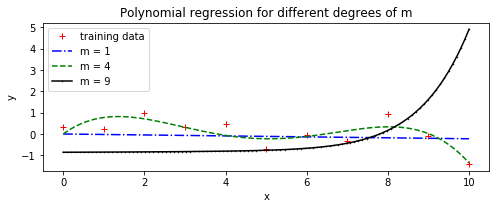

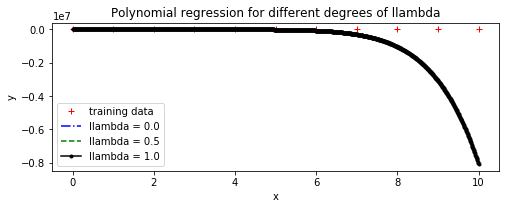

In [6]:
test_polynomial_regression()  

In the first plot (ridge-regularization-parameter lambda = 0) one can observe 
that for higher values of m the data-points are usually 'hit' better, 
meaning that more of the data-points are included in the respective plot.
That makes sense, as higher order polynomials are more 'powerful' and can 
trace data better. 
However, as we know that the underlying function that generates the data is a
sine-curve, high values of m seem to overfit the gaussian noise in the data.
In the second plot (polynomial-order m = 9). A small value of lambda generates
curves that are similar to the first plot. Larger values of lambda generate curves 
that don't show such strong overfitting as larger values of the weight-vector
are penalized more (weight-vector is basically smoothed).

In the first case (lambda fixed to zero) we would choose m = 5. In the second case
(m = 9) we would choose lambda = 0.8. 

We do not expect those parameters to perform well on all possible data-sets.
The reason being that currently we only look at data of a noisy sine-curve
between roughly zero and three pi. The longer the sine-curve however, the more
powerful (higher degree m) a polynomial would have to be to be able to trace the
data somewhat accurately. Of course, the same goes for data that was generated
completely differently (different underlying function)
The same is true for the regularization parameter lambda, but in the reverse.
For 'shorter' sine-curves more regularization might be necessary; and different
data-generation might require different parameteres altogether.